In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import numpy as np
import torch.nn.functional as F

In [ ]:
import torchvision
from torchvision import datasets
train_data =datasets.MNIST(root="data",train=True,download=True,transform=torchvision.transforms.ToTensor())
train_data,val_data=random_split(train_data,[50000,10000])
test_data =datasets.MNIST(root="data",train=False,download=True,transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.69MB/s]


In [ ]:
print(train_data[0][0].squeeze().shape)

torch.Size([28, 28])


In [ ]:
def conversion_to_one_hot(dataset):
  new_dataset=[]
  for data in dataset:
    data_1=data[0]
    one_hot=torch.zeros(10)
    one_hot[data[1]]=1
    new_dataset.append((data_1,one_hot))
  return new_dataset

In [ ]:
# train_data_1=conversion_to_one_hot(train_data)
# val_data_1=conversion_to_one_hot(val_data)
# test_data_1=conversion_to_one_hot(test_data)
print(f"Length of train_data :{len(train_data)} | val_data :{len(val_data)} | test_data :{len(test_data)}")

Length of train_data :50000 | val_data :10000 | test_data :10000


In [ ]:
train_data_loader=DataLoader(train_data,batch_size=64,shuffle=True)
val_data_loader=DataLoader(val_data,batch_size=64,shuffle=True)
test_data_loader=DataLoader(test_data,batch_size=64,shuffle=False)

In [ ]:
print(train_data[0][0].shape)

torch.Size([1, 28, 28])


In [ ]:
class CNN(nn.Module):
  def __init__(self,in_filter_depth=1,conv_channel_depth=32,kernel_size=3,stride=1,padding=1):
    super().__init__()
    self.conv1=nn.Sequential(nn.Conv2d(in_channels=in_filter_depth,out_channels=conv_channel_depth,kernel_size=kernel_size,stride=stride,padding=padding),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2,stride=2))
    self.conv2=nn.Sequential(nn.Conv2d(in_channels=conv_channel_depth,out_channels=conv_channel_depth,kernel_size=kernel_size,stride=stride,padding=padding),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2,stride=2))
    self.fc=nn.Sequential(nn.Flatten(),
                          nn.Linear(32*7*7,500),
                          nn.ReLU(),
                          nn.Linear(500,10),
                          )
  def forward(self,x):
    #print(f"x:{x.shape}")
    x_1=self.conv1(x)
    #print(f"x_1:{x_1.shape}")
    x_2=self.conv2(x_1)
    #print(f"x_2: {x_2.shape}")
    x_3=self.fc(x_2)
    #print(f"x_3:{x_3.shape}")
    last_func=nn.Softmax(dim=1)
    x_4=last_func(x_3)
    return x_3,x_4

In [ ]:
model=CNN(1,32,3,1,1)
model.forward(train_data[0][0].unsqueeze(0))

x:torch.Size([1, 1, 28, 28])
x_1:torch.Size([1, 32, 14, 14])
x_2: torch.Size([1, 32, 7, 7])
x_3:torch.Size([1, 10])


(tensor([[-0.0383, -0.0729, -0.0739, -0.0072, -0.0034, -0.0245, -0.0175, -0.0173,
           0.0221,  0.0222]], grad_fn=<AddmmBackward0>),
 tensor([[0.0982, 0.0949, 0.0948, 0.1013, 0.1017, 0.0996, 0.1003, 0.1003, 0.1044,
          0.1044]], grad_fn=<SoftmaxBackward0>))

In [ ]:
def train(train_data_loader,val_data_loader,test_data_loader,model,optimizer,loss_fn,epochs):
  train_loss=[]
  val_loss_arr=[]
  test_acc=[]
  for epoch in range(epochs):
    loss_value=0
    freq=0
    model.train()
    for data in train_data_loader:
      data_1,label=data[0].to(device),data[1].to(device)
      # print(data[0].shape,data[1].shape)
      optimizer.zero_grad()
      prediction,pred_softmax = model(data_1)
      # print(prediction.shape,pred_softmax.shape)
      loss=loss_fn(prediction,label)
      loss_value+=loss.item()
      freq+=1
      # print(loss)
      loss.backward()
      optimizer.step()
    train_loss.append(loss_value/freq)
    val_loss_value=0
    val_freq=0
    model.eval()
    with torch.no_grad():
      for val_data in val_data_loader:
        val_data_1,val_label=val_data[0].to(device),val_data[1].to(device)
        val_prediction,val_pred_softmax=model(val_data_1)
        val_loss=loss_fn(val_prediction,val_label)
        val_loss_value+=val_loss.item()
        val_freq+=1
      val_loss_arr.append(val_loss_value/val_freq)
      test_crct=0
      total=0
      for test_data in test_data_loader:
        test_data_1,test_label=test_data[0].to(device),test_data[1].to(device)
        test_prediction,test_pred_softmax=model(test_data_1)
        test_pred=torch.argmax(test_pred_softmax,dim=1)
        total+=test_label.size(0)
        test_crct+=(test_pred==test_label).sum().item()
      test_acc.append(test_crct/total)
    print(f"epoch_number:{epoch+1}/{epochs} | train_loss: {train_loss[epoch]} | val_loss={val_loss_arr[epoch]} | test_acc={test_acc[epoch]}")
  return train_loss,val_loss_arr,test_acc


In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
model=CNN(1,32,3,1,1)
model.to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn=nn.CrossEntropyLoss()
train_loss,val_loss,test_acc= train(train_data_loader,val_data_loader,test_data_loader,model,optimizer,loss_fn,15)

epoch_number:1/15 | train_loss: 0.18948403633970176 | val_loss=0.06359985591191206 | test_acc=0.9837
epoch_number:2/15 | train_loss: 0.05321417687921678 | val_loss=0.055338619629834676 | test_acc=0.9841
epoch_number:3/15 | train_loss: 0.03577293763952473 | val_loss=0.04638425142327798 | test_acc=0.9878
epoch_number:4/15 | train_loss: 0.025163321568214696 | val_loss=0.03119703599624039 | test_acc=0.9899
epoch_number:5/15 | train_loss: 0.020405314692357197 | val_loss=0.03819266579334126 | test_acc=0.9881
epoch_number:6/15 | train_loss: 0.014467837233461648 | val_loss=0.04322811799833127 | test_acc=0.9894
epoch_number:7/15 | train_loss: 0.013357882091189627 | val_loss=0.04278939521287948 | test_acc=0.9884
epoch_number:8/15 | train_loss: 0.009933373666253386 | val_loss=0.037884142636068215 | test_acc=0.9907
epoch_number:9/15 | train_loss: 0.008563353232101552 | val_loss=0.03710299299563923 | test_acc=0.9914
epoch_number:10/15 | train_loss: 0.007410424233769198 | val_loss=0.0436327439794382

1.1 . PLOTS OF TRAINING ERROR, VALIDATION ERROR AND PREDICTION ACCURACY

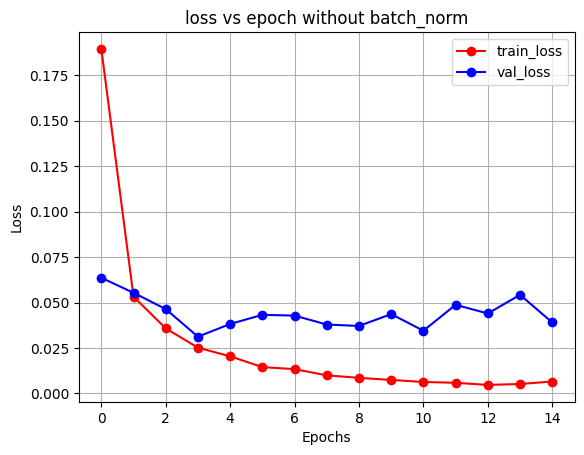

In [ ]:
plt.plot(range(15),train_loss,c="r",marker="o",label="train_loss")
plt.plot(range(15),val_loss,c="b",marker="o",label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch without batch_norm")
plt.grid(True)
plt.legend()
plt.show()

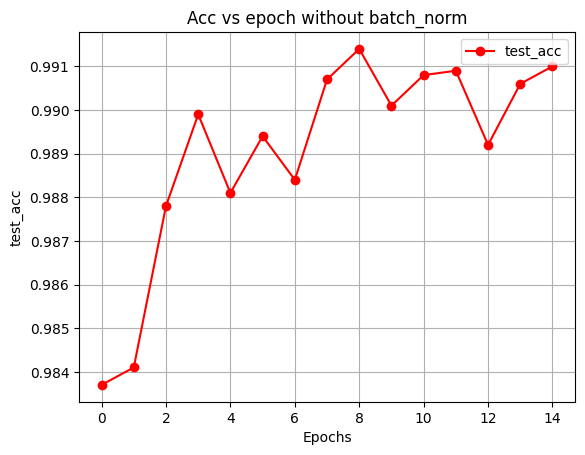

In [ ]:
plt.plot(range(15),test_acc,c="r",marker="o",label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("test_acc")
plt.title("Acc vs epoch without batch_norm")
plt.grid(True)
plt.legend()
plt.show()

PREDICTION ACCURACY FOR THE WHOLE TEST SET = 99.1 %

SAVING THE MODEL PARAMETERS INTO G-DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_path="/content/drive/MyDrive/CNN_assign_model.pth"
torch.save(model.state_dict(),model_path)
print(f"model saved at {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
model saved at /content/drive/MyDrive/CNN_assign_model.pth


1.2 . DISPLAYING RANDOMLY SELECTED TEST IMAGES

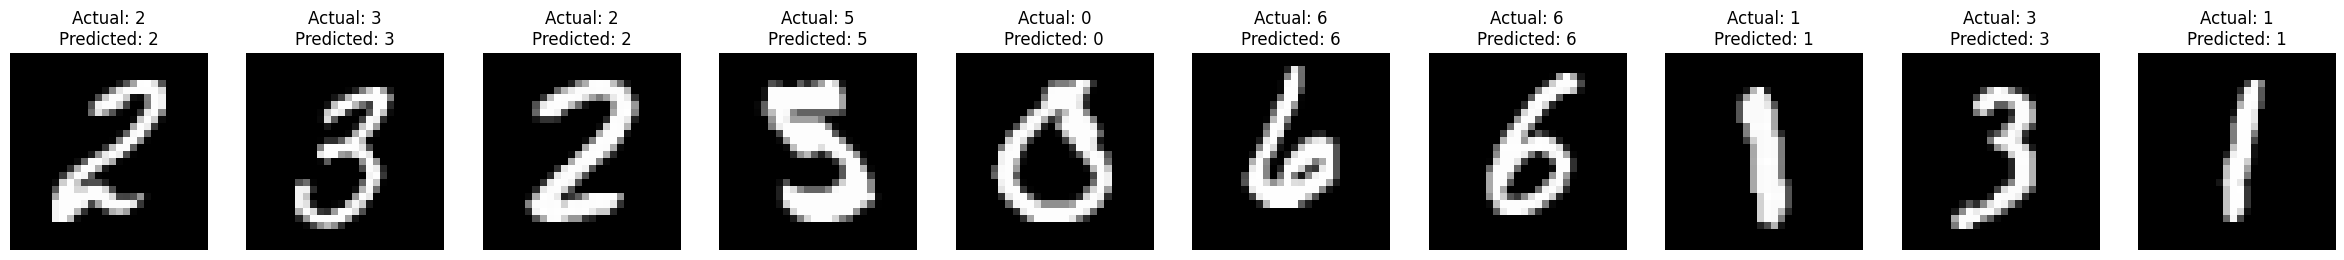

In [ ]:
plt.figure(figsize=(30, 3))
random_test=torch.randint(0,10000,(10,))
index=0
for i in random_test:
  img,actual_value=test_data[i.item()]
  img = img.unsqueeze(0)
  _,predict=model.forward(img.to(device))
  predicted_value=torch.argmax(predict)
  # print(predicted_value)
  plt.subplot(1, 10, index + 1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Actual: {actual_value}\nPredicted: {predicted_value.item()}")
  plt.axis('off')
  index+=1

1.3 . DIMENSIONS OF INPUT AND OUTPUT AT EACH LAYER

    LAYER_1: INPUT:[BS,1,28,28] OUTPUT:[BS,32,28,28] -CONV1
    
    LAYER_2: INPUT:[BS,32,28,28] OUTPUT:[BS,32,14,14] -MAXPOOL

    LAYER_3: INPUT:[BS,32,14,14] OUTPUT:[BS,32,14,14] -CONV2

    LAYER_4: INPUT:[BS,32,14,14] OUTPUT:[BS,32,7,7] -MAXPOOL

    FC (NEURON NUMBERS):      INPUT:[BS,1568] OUTPUT:[BS,500]

    FC (NEURON NUMBERS):      INPUT:[BS,500] OUTPUT:[BS,10]


BS - Batch size



1.4. PARAMETERS OF THE NETWORK


In [ ]:
conv_params=0
fc_params=0
for param in model.conv1.parameters():
  conv_params+=param.numel()
for param in model.conv2.parameters():
  conv_params+=param.numel()
for param in model.fc.parameters():
  fc_params+=param.numel()
print(f"conv_params:{conv_params} | fc_params:{fc_params}")
print(f"Convolutional layers parameters: {conv_params:,}")
print(f"Fully connected layers parameters: {fc_params:,}")
print(f"Total trainable parameters: {conv_params + fc_params:,}")

conv_params:9568 | fc_params:789510
Convolutional layers parameters: 9,568
Fully connected layers parameters: 789,510
Total trainable parameters: 799,078


1.5: NETWORK PARAMETER COUNT:

CONV_1_NEURONS: 32 * 28 * 28 = 25088

CONV_2_NEURONS: 32 * 14 * 14 = 6272

TAOTAL CONVOLUTIONAL NEURON =31,360

FC_NEURONS: 500 + 10 = 510

TOTAL NEURONS: 31870

1.6 . MODEL CREATED WITH BATCH - NORMALIZATION

---




In [ ]:
class CNN_batch_norm(nn.Module):
  def __init__(self,in_filter_depth=1,conv_channel_depth=32,kernel_size=3,stride=1,padding=1):
    super().__init__()
    self.conv1=nn.Sequential(nn.Conv2d(in_channels=in_filter_depth,out_channels=conv_channel_depth,kernel_size=kernel_size,stride=stride,padding=padding),
                             nn.BatchNorm2d(conv_channel_depth),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2,stride=2))
    self.conv2=nn.Sequential(nn.Conv2d(in_channels=conv_channel_depth,out_channels=conv_channel_depth,kernel_size=kernel_size,stride=stride,padding=padding),
                             nn.BatchNorm2d(conv_channel_depth),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2,stride=2))
    self.fc=nn.Sequential(nn.Flatten(),
                          nn.Linear(32*7*7,500),
                          nn.BatchNorm1d(500),
                          nn.ReLU(),
                          nn.Linear(500,10),
                          )
  def forward(self,x):
    #print(f"x:{x.shape}")
    x_1=self.conv1(x)
    #print(f"x_1:{x_1.shape}")
    x_2=self.conv2(x_1)
    #print(f"x_2: {x_2.shape}")
    x_3=self.fc(x_2)
    #print(f"x_3:{x_3.shape}")
    last_func=nn.Softmax(dim=1)
    x_4=last_func(x_3)
    return x_3,x_4

In [ ]:
model_batch_norm=CNN_batch_norm(1,32,3,1,1)
model_batch_norm.to(device)
optimizer=torch.optim.Adam(model_batch_norm.parameters(),lr=0.001)
loss_fn=nn.CrossEntropyLoss()
train_loss,val_loss,test_acc= train(train_data_loader,val_data_loader,test_data_loader,model_batch_norm,optimizer,loss_fn,15)

epoch_number:1/15 | train_loss: 0.09290296653829887 | val_loss=0.047557438381170485 | test_acc=0.9874
epoch_number:2/15 | train_loss: 0.03618031332474452 | val_loss=0.04064183827166321 | test_acc=0.9865
epoch_number:3/15 | train_loss: 0.02278015768853501 | val_loss=0.0429463546812478 | test_acc=0.9889
epoch_number:4/15 | train_loss: 0.018613025426848694 | val_loss=0.03652751153007974 | test_acc=0.9906
epoch_number:5/15 | train_loss: 0.013114246267630273 | val_loss=0.03555272927301621 | test_acc=0.9892
epoch_number:6/15 | train_loss: 0.011217502686745704 | val_loss=0.032412277840472355 | test_acc=0.9891
epoch_number:7/15 | train_loss: 0.009481456787705242 | val_loss=0.030730690473499137 | test_acc=0.9905
epoch_number:8/15 | train_loss: 0.007515167415211581 | val_loss=0.0412859067504669 | test_acc=0.9916
epoch_number:9/15 | train_loss: 0.008372369204069335 | val_loss=0.043558037280913564 | test_acc=0.9889
epoch_number:10/15 | train_loss: 0.008042999606586842 | val_loss=0.0335720652796643

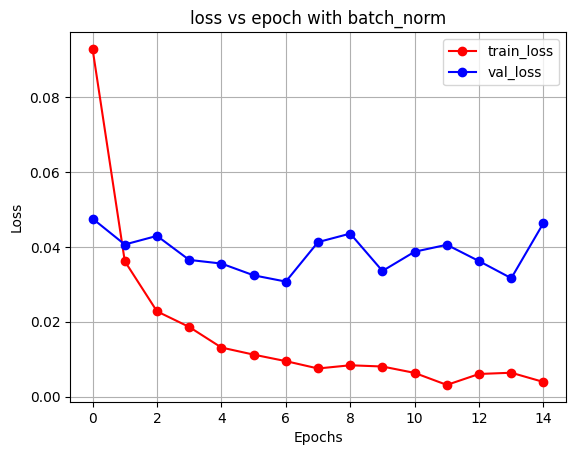

In [ ]:
plt.plot(range(15),train_loss,c="r",marker="o",label="train_loss")
plt.plot(range(15),val_loss,c="b",marker="o",label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch with batch_norm")
plt.grid(True)
plt.legend()
plt.show()

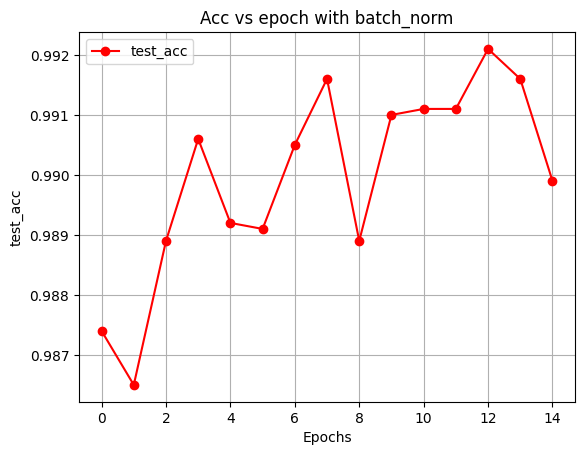

In [ ]:
plt.plot(range(15),test_acc,c="r",marker="o",label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("test_acc")
plt.title("Acc vs epoch with batch_norm")
plt.grid(True)
plt.legend()
plt.show()

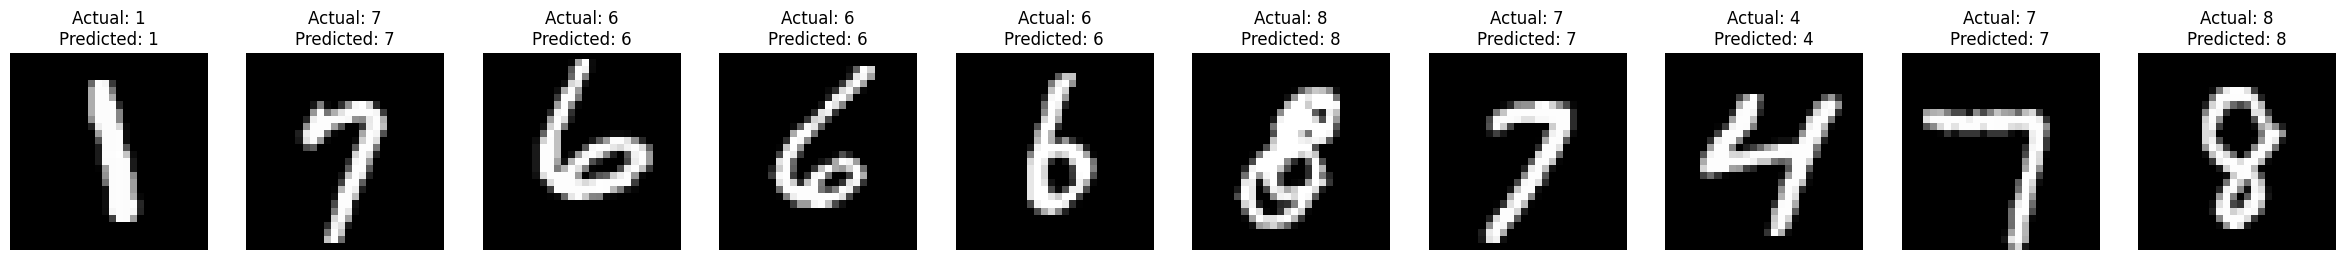

In [ ]:
plt.figure(figsize=(30, 3))
random_test=torch.randint(0,10000,(10,))
index=0
for i in random_test:
  img,actual_value=test_data[i.item()]
  img = img.unsqueeze(0)
  _,predict=model_batch_norm.forward(img.to(device))
  predicted_value=torch.argmax(predict)
  # print(predicted_value)
  plt.subplot(1, 10, index + 1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Actual: {actual_value}\nPredicted: {predicted_value.item()}")
  plt.axis('off')
  index+=1

Result:

Batch Normalization did not improve the test accuracy to a greater extent.
Both accuracy are almost same. The best test accuracy with BN is 99.21% and without BN is 99.14%

Batch Normalization would have increased the training time slightly due to extra computations.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_path="/content/drive/MyDrive/CNN_assign_model_withbn.pth"
torch.save(model_batch_norm.state_dict(),model_path)
print(f"model saved at {model_path}")

2. VISUALIZING CONVOLUTIONAL NEURAL NETWORK:

In [ ]:
#loading the saved model from drive
from google.colab import drive
drive.mount('/content/drive')
model=CNN(1,32,3,1,1)
model_path="/content/drive/MyDrive/CNN_assign_model.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

Mounted at /content/drive


<All keys matched successfully>

2.1 CONV1 LAYER FILTERS

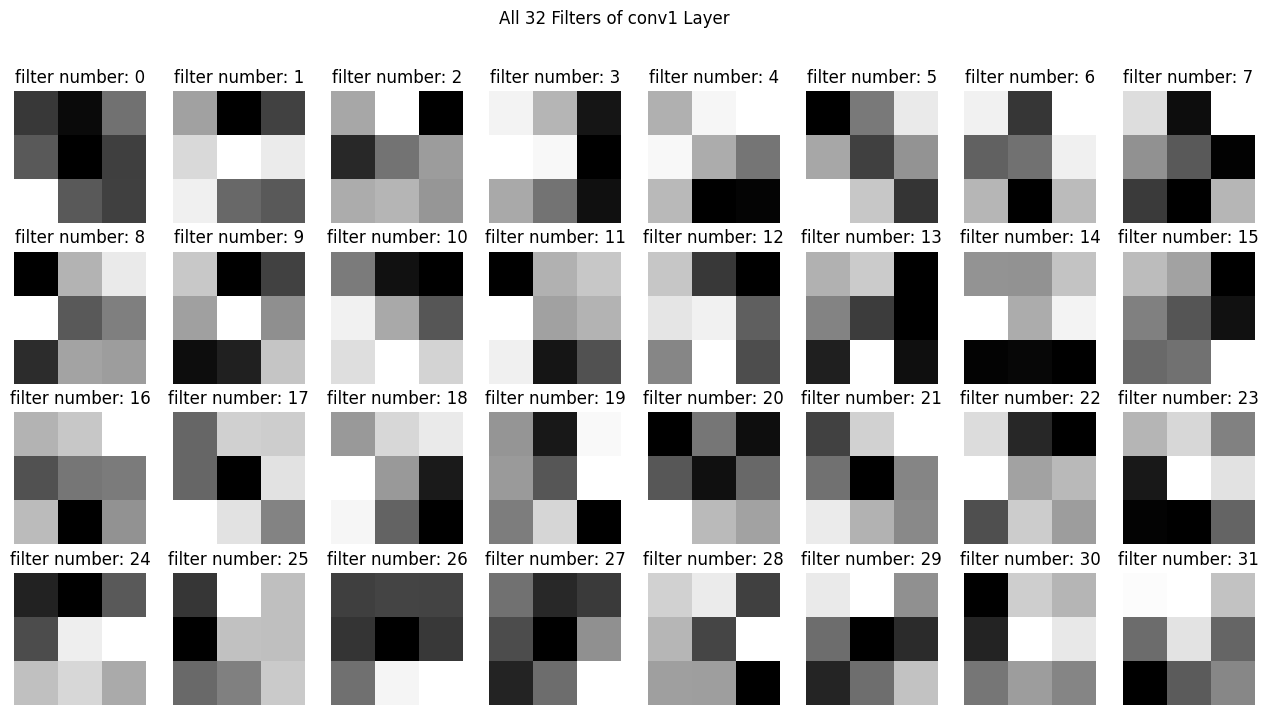

In [ ]:
plt.figure(figsize=(16,8))
index=0
for filters in model.state_dict()["conv1.0.weight"]:
  plt.subplot(4,8,index+1)
  plt.imshow(filters.squeeze(),cmap="grey")
  plt.axis("off")
  plt.title(f"filter number: {index}")
  index+=1
plt.suptitle("All 32 Filters of conv1 Layer")
plt.show()

2.2 FILTERS OF HIGHER LAYER

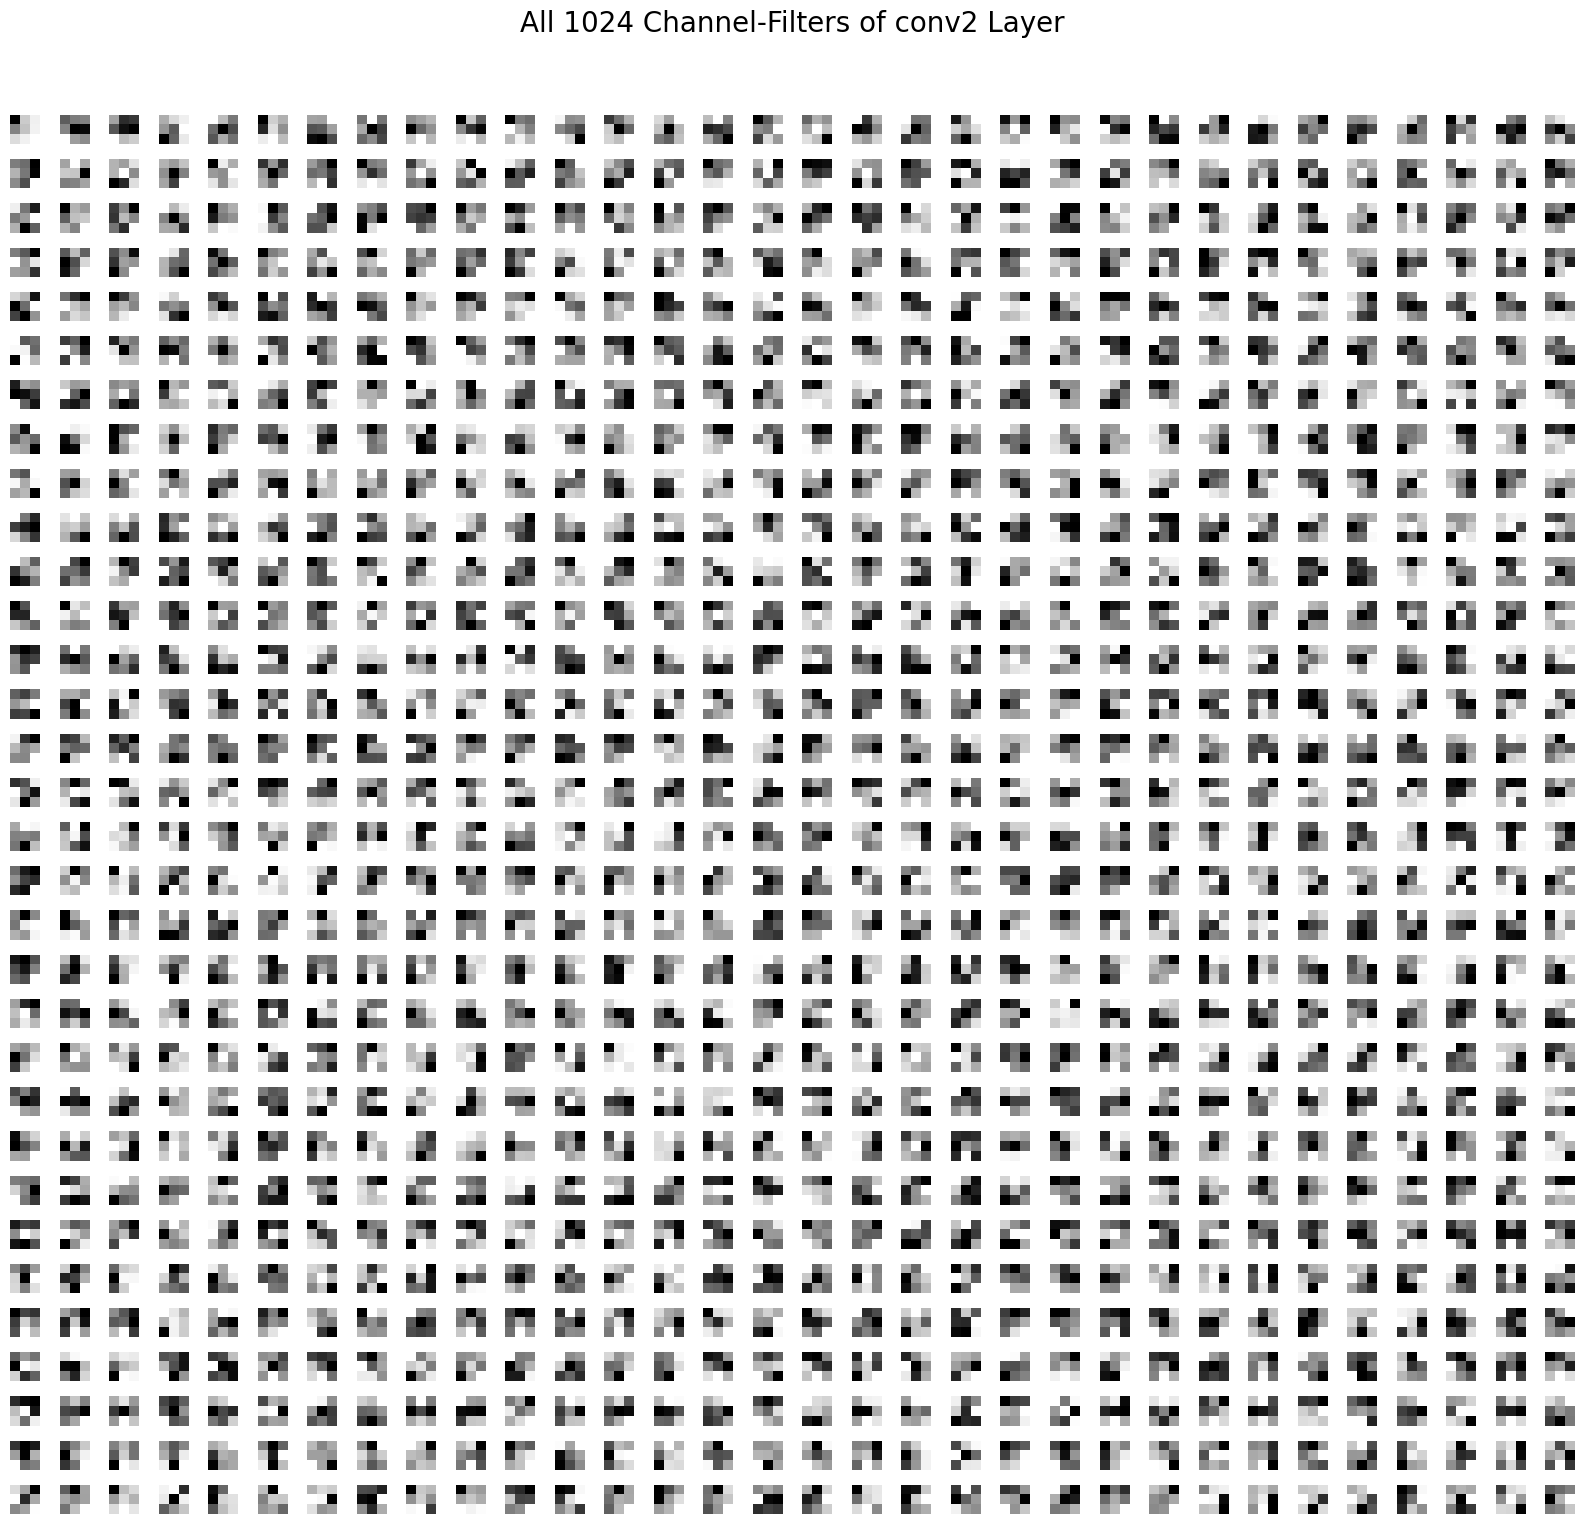

In [ ]:
import torch
import matplotlib.pyplot as plt

model.cpu()
weights = model.state_dict()["conv2.0.weight"]

grid_size = 32

plt.figure(figsize=(16, 16))
plt.suptitle("All 1024 Channel-Filters of conv2 Layer", fontsize=20)


for output_idx, output_filter in enumerate(weights):
    for input_idx in range(output_filter.shape[0]):
        plot_index = output_idx * grid_size + input_idx + 1
        plt.subplot(grid_size, grid_size, plot_index)
        channel_filter = output_filter[input_idx].detach()
        plt.imshow(channel_filter, cmap="gray")
        plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

OBSERVATION FOR 2.1 & 2.2

Comparison between Conv1 and Conv2 Filters:
- Conv1 filters (learned from raw pixels) are simpler and capture basic patterns like edges, gradients, and simple textures.
- Conv2 filters operate on the feature maps from Conv1. They learn to combine the basic patterns from the first layer into more complex and abstract features. As a result, they often appear more intricate and less directly interpretable than Conv1 filters

2.3. VISUALIZING THE ACTIVATIONS

VISUALIZING CONV1 LAYER ACTIVATION

In [ ]:
plt.figure(figsize=(16,8))
index=0
for filters in model.state_dict()["conv1.0.weight"]:
  plt.subplot(4,8,index+1)
  plt.imshow(filters.squeeze(),cmap="grey")
  plt.axis("off")
  plt.title(f"filter number: {index}")
  index+=1
plt.suptitle("All 32 Filters of conv1 Layer")
plt.show()

(np.float64(-0.5), np.float64(13.5), np.float64(13.5), np.float64(-0.5))

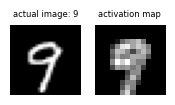

In [ ]:
num=torch.randint(0,60000,(1,))
plt.figure(figsize=(2, 1))
plt.subplot(1,2,1)
plt.imshow(train_data[num][0].squeeze(),cmap="grey")
plt.title(f"actual image: {train_data[num][1]}",fontsize=6)
plt.axis(False)


arr=model.conv1(train_data[num][0].unsqueeze(0)).detach().numpy().squeeze()
res_arr=np.zeros(arr.shape[1:])
for i in range(arr.shape[0]):
  res_arr+=arr[i]
res_arr=res_arr/arr.shape[0]
plt.subplot(1,2,2)
plt.imshow(res_arr,cmap="grey")
plt.title("activation map",fontsize=6)
plt.axis(False)


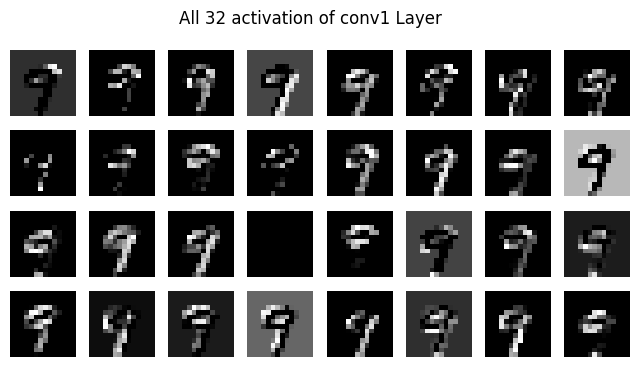

In [ ]:
plt.figure(figsize=(8,4))
for i in range(arr.shape[0]):
  plt.subplot(4,8,i+1)
  plt.imshow(arr[i],cmap="grey")
  plt.axis(False)
  # plt.title(f"filter number: {i+1}")
plt.suptitle("All 32 activation of conv1 Layer")
plt.show()



VISUALIZING CONV2 LAYER ACTIVATION

(32, 7, 7)


(np.float64(-0.5), np.float64(6.5), np.float64(6.5), np.float64(-0.5))

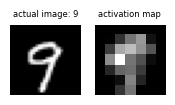

In [ ]:
deep_arr=model.conv2(model.conv1(train_data[num][0].unsqueeze(0))).detach().numpy().squeeze()
print(deep_arr.shape)
plt.figure(figsize=(2, 1))
plt.subplot(1,2,1)
plt.imshow(train_data[num][0].squeeze(),cmap="grey")
plt.title(f"actual image: {train_data[num][1]}",fontsize=6)
plt.axis(False)
res_arr=np.zeros(deep_arr.shape[1:])
for i in range(deep_arr.shape[0]):
  res_arr+=deep_arr[i]
res_arr=res_arr/deep_arr.shape[0]
plt.subplot(1,2,2)
plt.imshow(res_arr,cmap="grey")
plt.title("activation map",fontsize=6)
plt.axis(False)

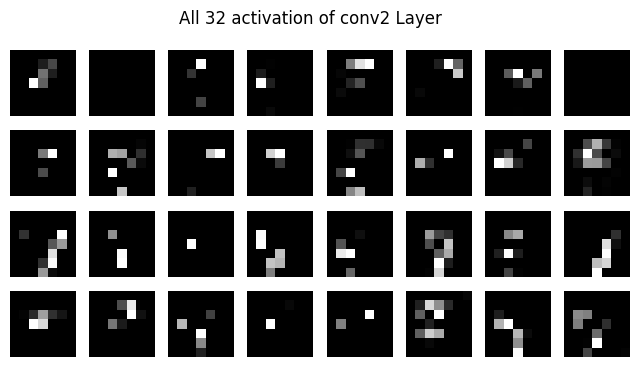

In [ ]:
plt.figure(figsize=(8,4))
for i in range(deep_arr.shape[0]):
  plt.subplot(4,8,i+1)
  plt.imshow(deep_arr[i],cmap="grey")
  plt.axis(False)
  # plt.title(f"filter number: {i+1}")
plt.suptitle("All 32 activation of conv2 Layer")
plt.show()

OBSERVATION FOR 2.3.

- As we go deeper into the network, the activations become more abstract and less visually interpretable.
- The Conv1 activations highlight simple features like edges and corners of the digit.
- The Conv2 activations are responses to more complex patterns built from the first layer's features. The spatial resolution (size of the feature map) is also smaller, meaning the features are more compressed.

2.4. OCCLUDING PARTS OF THE IMAGE

Original image label: 8


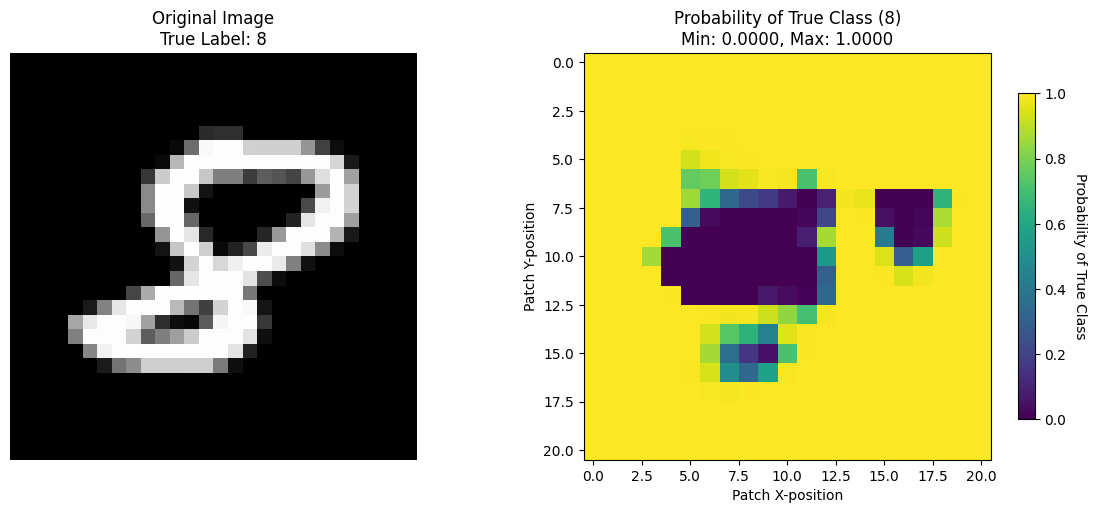

In [ ]:
def occlusion_fixed(model, image, label, patch_size=4, stride=1):
    device=next(model.parameters()).device
    model.eval()
    width, height = image.shape[2], image.shape[1]
    image = image.unsqueeze(0)
    output_height = (height - patch_size) // stride + 1
    output_width = (width - patch_size) // stride + 1
    heat_map = torch.zeros((output_height, output_width))
    for h in range(output_height):
        for w in range(output_width):
            h_start, w_start = h * stride, w * stride
            h_end, w_end = h_start + patch_size, w_start + patch_size
            occluded_image = image.clone()
            occluded_image[:, :, h_start:h_end, w_start:w_end] = 0
            with torch.no_grad():
                output,_ = model(occluded_image.to(device))
                prob = F.softmax(output, dim=1)
                prob = prob[0, label].item()

            heat_map[h, w] = prob

    return heat_map.cpu().numpy()

print(f"Original image label: {test_data[61][1]}")

image_to_test = test_data[61][0]
label_to_test = test_data[61][1]
patch_size = 8
heatmap_probs = occlusion_fixed(model, image_to_test, label_to_test, patch_size, 1)

min_prob = np.min(heatmap_probs)
max_prob = np.max(heatmap_probs)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(image_to_test.squeeze(), cmap='gray')
axes[0].set_title(f'Original Image\nTrue Label: {label_to_test}')
axes[0].axis('off')
im = axes[1].imshow(heatmap_probs, cmap='viridis',
                    vmin=0.0, vmax=1.0,
                    interpolation='none')

axes[1].set_title(f'Probability of True Class ({label_to_test})\nMin: {min_prob:.4f}, Max: {max_prob:.4f}')
axes[1].set_xlabel('Patch X-position')
axes[1].set_ylabel('Patch Y-position')

cbar = fig.colorbar(im, ax=axes[1], orientation='vertical', shrink=0.8)
cbar.set_label('Probability of True Class', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

OBSERVATION FOR 2.4.

The occlusion experiment demonstrates that the model's confidence in the true class drops significantly only when the occluding patch covers the actual strokes of the digit '8'. This shows the network has learned to focus on the semantically important features of the digit itself, rather than the background. Therefore, the experiment confirms that the model's learning is meaningful.


3. ADVERSARIAL EXAMPLES

3.1. NON TARGETED ATTACK

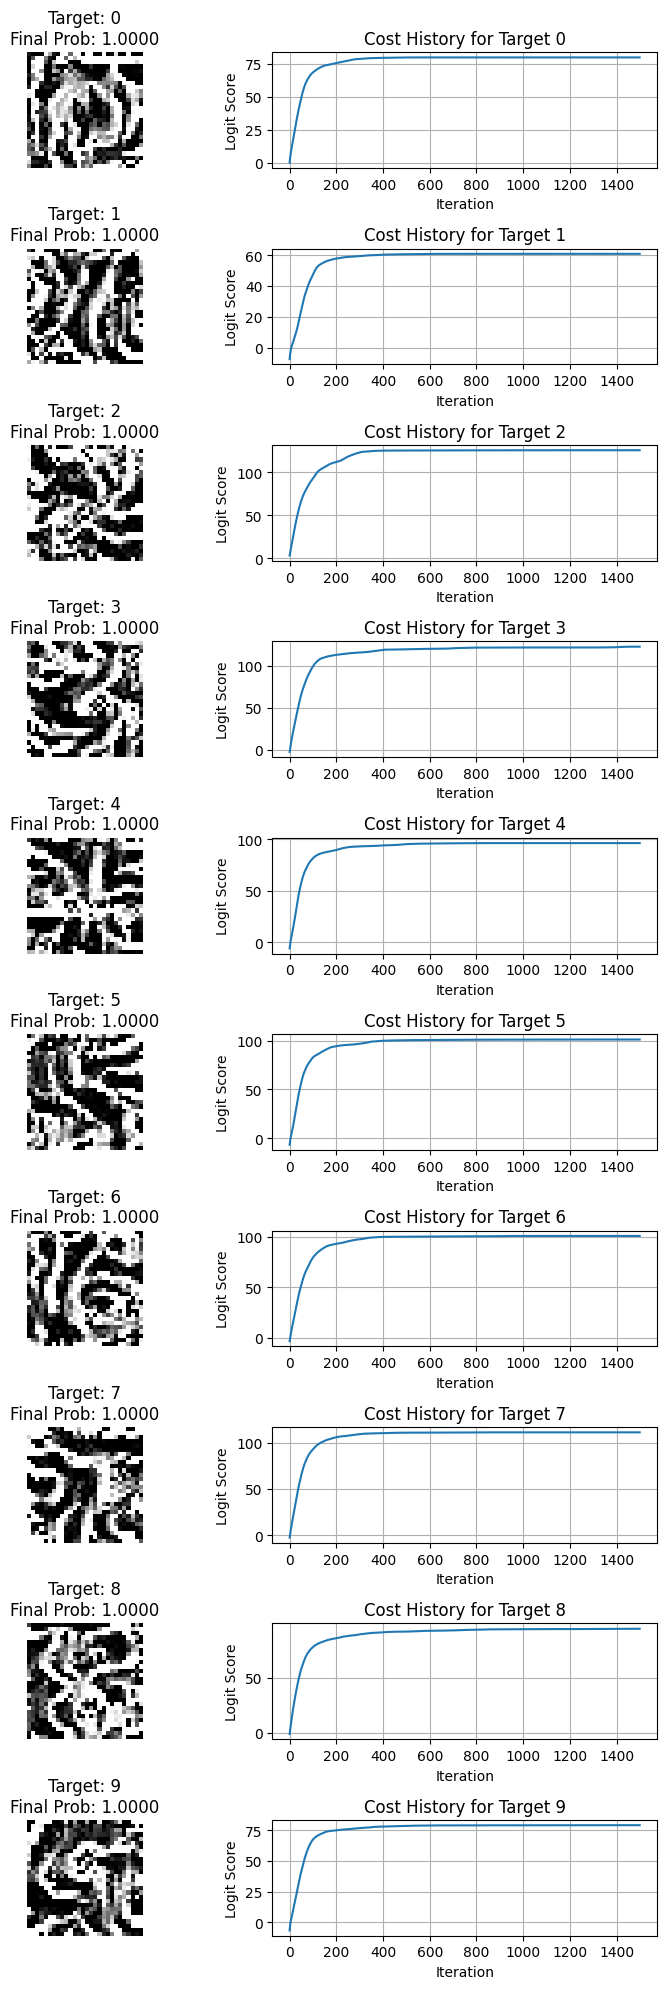

In [ ]:
random_noise=torch.normal(mean=0.5,std=0.25,size=(1,1,28,28),device=device,requires_grad=True)
def non_targeted_attack(model,random_noise,target_class,steps=1500,step_size=0.01):
  model.eval()
  cost=[]
  optimizer=torch.optim.Adam([random_noise],lr=step_size)
  for i in range(steps):
    optimizer.zero_grad()
    output,_=model.forward(random_noise)
    loss=-output[0,target_class]
    cost.append(-loss.item())
    loss.backward()
    optimizer.step()
    random_noise.data.clamp_(0,1)
  return random_noise,cost
plt.figure(figsize=(8, 20))

for i in range(10):
    random_noise = torch.normal(mean=0.5, std=0.25, size=(1, 1, 28, 28),
                                device=device, requires_grad=True)
    target = i
    out_tensor, cost = non_targeted_attack(model, random_noise, target)
    with torch.no_grad():
        final_output,_ = model(out_tensor)
        final_probs = F.softmax(final_output, dim=1)
        final_prob_for_target = final_probs[0, target].item()
    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(out_tensor.detach().cpu().squeeze(), cmap="gray")
    plt.title(f"Target: {target}\nFinal Prob: {final_prob_for_target:.4f}")
    plt.axis("off")
    plt.subplot(10, 2, 2*i + 2)
    plt.plot(cost)
    plt.title(f"Cost History for Target {target}")
    plt.xlabel("Iteration")
    plt.ylabel("Logit Score")
    plt.grid(True)

plt.tight_layout()

plt.show()




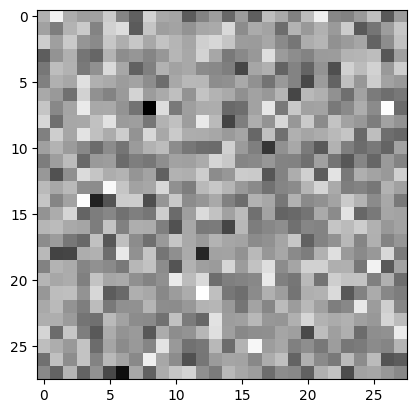

In [ ]:
plt.imshow(random_noise.squeeze(),cmap="gray")

3.1.1 SHOWN ABOVE

3.1.2 Yes , The model is predicting the target_class with very high confidence(as PROBABILITY is 1)

3.1.3 No, they dont look like numbers. They look like noisy patterns. This is because the model is choosing the most efficient pattern of pixels that trigger the target_class. Gradient ascent finds the perfect , minimalist combination of the features that represent target_class.This "perfect" pattern doesn't need to form a coherent shape that a human would recognize; it just needs to be an optimal trigger for the network's learned logic.

3.1.4 The cost function is increasing. This is expected because we are using gradient ASCENT to maximize the logit value for the target class. The plot confirms this upward trend.

3.2. TARGETED ATTACK

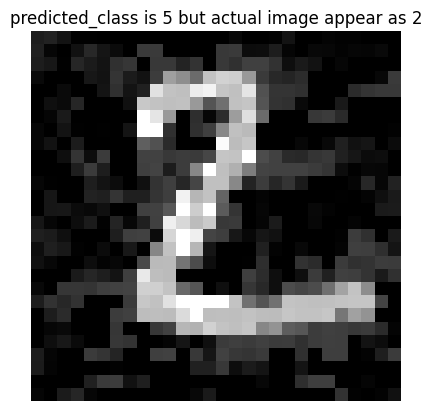

In [ ]:
def targeted_attack(model,image,target_class,steps=1500,step_size=0.01,beta=0.00001):
  model.eval()
  generated_image=image.clone().detach().requires_grad_(True)
  optimizer=torch.optim.Adam([generated_image],lr=step_size)
  for i in range(steps):
    optimizer.zero_grad()
    output,_=model.forward(generated_image)
    loss=-output[0,target_class]+beta*F.mse_loss(generated_image,image)
    loss.backward()
    optimizer.step()
    generated_image.data.clamp_(0,1)
  return generated_image


image=targeted_attack(model,test_data[1][0].unsqueeze(0),5,steps=25,step_size=0.01,beta=0.00001)
plt.imshow(image.detach().cpu().squeeze(),cmap="gray")
_,output=model.forward(image)
plt.title(f"predicted_class is {torch.argmax(output)} but actual image appear as {test_data[1][1]}")
plt.axis("off")
plt.show()

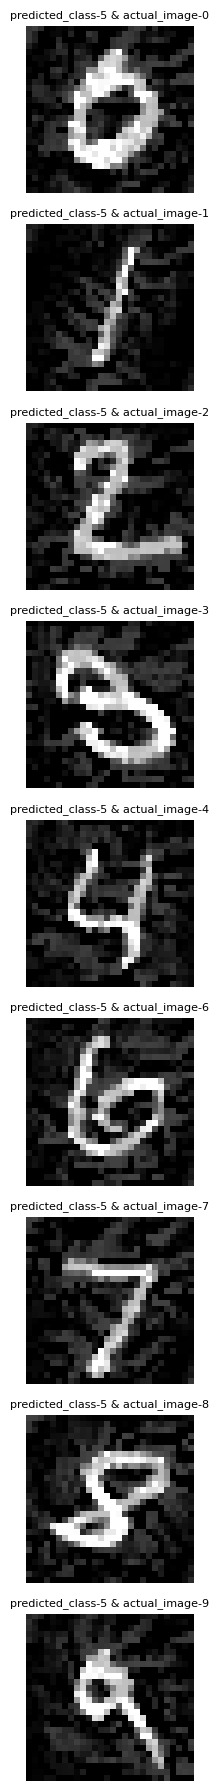

In [ ]:
attacks=[3,2,1,18,4,8,11,0,61,7]
plt.figure(figsize=(8, 20))
target_class=5
index=1
for i,val in enumerate(attacks):
    if i==target_class:
      continue
    out_tensor = targeted_attack(model, test_data[val][0].unsqueeze(0) , target_class,steps=25,step_size=0.01,beta=0.00001)
    with torch.no_grad():
        _,final_output = model(out_tensor)
    plt.subplot(10, 1, index)
    plt.imshow(out_tensor.detach().cpu().squeeze(), cmap="gray")
    plt.title(f"predicted_class-{torch.argmax(final_output)} & actual_image-{test_data[val][1]}",fontsize=8)
    plt.axis("off")
    index+=1
# plt.suptitle("Targeted adversarial attack",fontsize=8)
plt.tight_layout()
plt.show()

3.2.1 AS SHOWN ABOVE, THE GENERATED IMAGE CLEARLY RESEMBLES THE DIGITS. DUE TO MSE TERM IN THE COST FUNCTION, THE OPTIMIZATION PROCESS FORCES THE IMAGE TO BE VISUALLY SIMILAR TO THE TARGET IMAGE. BUT IT CLASSIFIES IT AS SOME OTHER NUMBER (TARGET_CLASS) BECAUSE OF logits[target class] IN LOSS FUNCTION.

Resources-[for data splitting](https://www.geeksforgeeks.org/deep-learning/how-to-split-a-dataset-using-pytorch/)

        -[transition from conv2d to linear layer](https://discuss.pytorch.org/t/transition-from-conv2d-to-linear-layer-equations/93850)